[//]: # (------------------------------------------    DO NOT MODIFY THIS    ------------------------------------------)
<style type="text/css">
.tg  {border-collapse:collapse;
      border-spacing:0;
     }
.tg td{border-color:black;
       border-style:solid;
       border-width:1px;
       font-family:Arial, sans-serif;
       font-size:14px;
       overflow:hidden;
       padding:10px 5px;
       word-break:normal;
      }
.tg th{border-color:black;
       border-style:solid;
       border-width:1px;
       font-family:Arial, sans-serif;
       font-size:14px;
       font-weight:normal;
       overflow:hidden;
       padding:10px 5px;
       word-break:normal;
      }
.tg .tg-fymr{border-color:inherit;
             font-weight:bold;
             text-align:left;
             vertical-align:top
            }
.tg .tg-0pky{border-color:inherit;
             text-align:left;
             vertical-align:top
            }
[//]: # (--------------------------------------------------------------------------------------------------------------)

[//]: # (-------------------------------------    FILL THIS OUT WITH YOUR DATA    -------------------------------------)
</style>
<table class="tg">
    <tbody>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Title:</td>
        <td class="tg-0pky">Notebook for model demonstrations - OneHealth Platform project</td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Authors:</td>
        <td class="tg-0pky">
            <a href="https://github.com/ecarrenolozano" target="_blank" rel="noopener noreferrer">Edwin Carreño</a>,
            <a href="" target="_blank" rel="noopener noreferrer">Inga Ulusoy</a>,
            <a href="" target="_blank" rel="noopener noreferrer">Harald Mack</a>
        </td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Affiliations:</td>
        <td class="tg-0pky">
            <a href="https://www.ssc.uni-heidelberg.de/en" target="_blank" rel="noopener noreferrer">Scientific Software Center</a>
        </td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Date Created:</td>
        <td class="tg-0pky">10th June, 2025</td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Description:</td>
        <td class="tg-0pky">Notebook for demonstrating the usage of the python implementation of the original R model shown in `model_r.ipynb`</td>
      </tr>
    </tbody>
</table>

[//]: # (--------------------------------------------------------------------------------------------------------------)

In [1]:
import model_backend as mdc
from pathlib import Path
import xarray as xr
import rioxarray as rioxr 
import numpy as np 

# Daily data - August 2024

## Build model instance

data is assumed to live in a directory: 

data/in

relative to the base directory of the package

In [2]:
path = Path.cwd().parent / "data" / "in"
path

PosixPath('/home/hmack/Development/onehealth-model-backend/data/in')

In [3]:
data_file = "ERA5land_global_t2m_dailyStats_mean_01Deg_2024_08_data.nc" 

In [4]:
model = mdc.JModel(
    input = path / data_file, 
    output = Path.cwd().parent / 'data' / "out" / "output_map.nc", 
    r0_path= path / "R0_pip_stats.csv",
    run_mode="forbidden", 
    grid_data_baseurl="https://gisco-services.ec.europa.eu/distribution/v2/nuts",
    nuts_level =3, 
    resolution = "10M", 
    year=2024, 
)

In [5]:
data = xr.open_dataset(
    path / data_file, chunks=None
)
data

<xarray.Dataset> Size: 804MB
Dimensions:     (valid_time: 31, latitude: 1801, longitude: 3600)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * valid_time  (valid_time) datetime64[ns] 248B 2024-08-01 ... 2024-08-31
  * longitude   (longitude) float64 29kB -179.9 -179.8 -179.7 ... 179.9 180.0
Data variables:
    t2m         (valid_time, latitude, longitude) float32 804MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-07T15:15 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
input = model.read_input_data().compute()


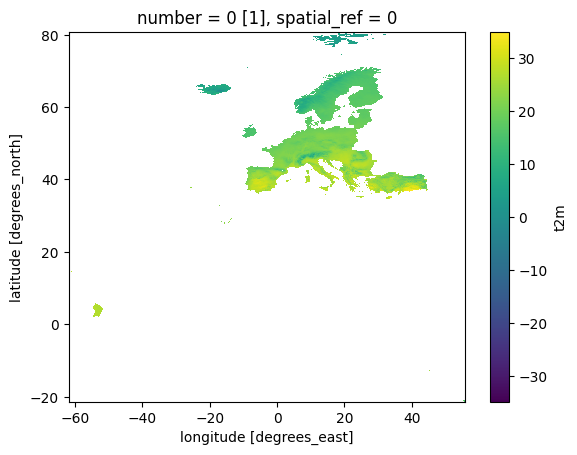

In [7]:
input["t2m"].mean(dim="valid_time").plot(cmap="viridis")

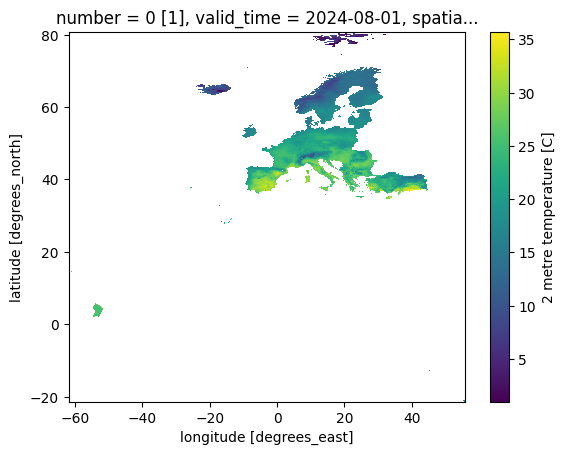

In [8]:
input["t2m"].sel(valid_time = "2024-08-01").plot(cmap="viridis")

## Run model -> load data -> apply model transformations -> save back to netcdf

In [9]:
model.run()

## Have a look at produced data

In [10]:
data = xr.open_dataset(
            Path.cwd().parent / 'data' / "out" / "output_map.nc", engine="rasterio"
        )

In [11]:
data

<xarray.Dataset> Size: 298MB
Dimensions:      (x: 1177, y: 1021, valid_time: 31)
Coordinates:
  * x            (x) float64 9kB -61.8 -61.7 -61.6 -61.5 ... 55.5 55.6 55.7 55.8
  * y            (y) float64 8kB 80.7 80.6 80.5 80.4 ... -21.0 -21.1 -21.2 -21.3
  * valid_time   (valid_time) object 248B 2024-08-01 00:00:00 ... 2024-08-31 ...
    spatial_ref  int64 8B ...
Data variables:
    R0           (valid_time, y, x) float64 298MB ...

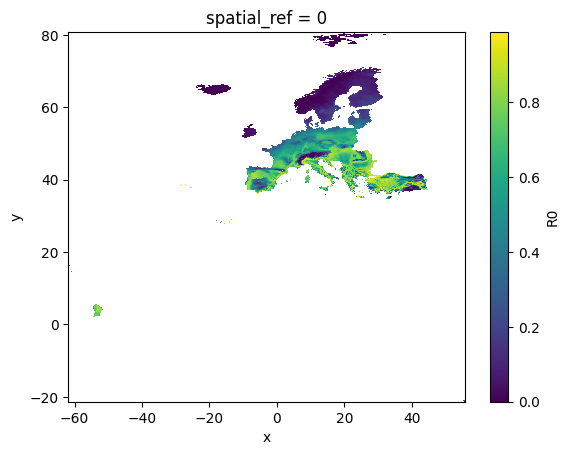

In [12]:
data["R0"].mean(dim="valid_time").plot(cmap="viridis")

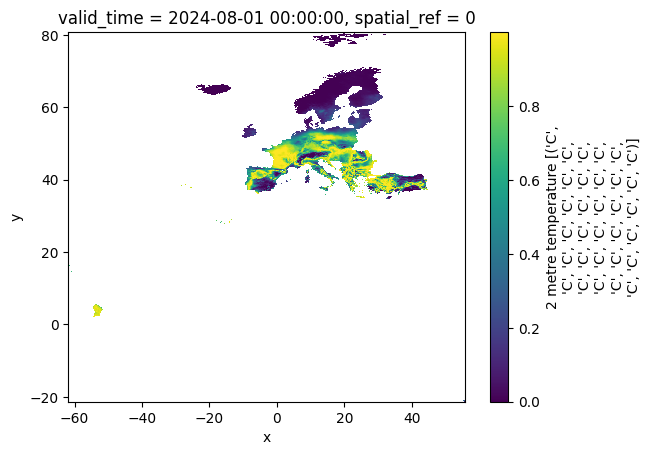

In [13]:
data["R0"].sel(valid_time="2024-08-01").plot(cmap="viridis")

## Run model with parallel run mode on a global scale

In [14]:
model = mdc.JModel(
    input = path / data_file, 
    output = Path.cwd().parent / 'data' / "out" / "output_map_global.nc", 
    r0_path= path / "R0_pip_stats.csv",
    run_mode="parallelized",
    grid_data_baseurl=None,
    nuts_level =None,
    resolution = None,
    year=None,
    
)

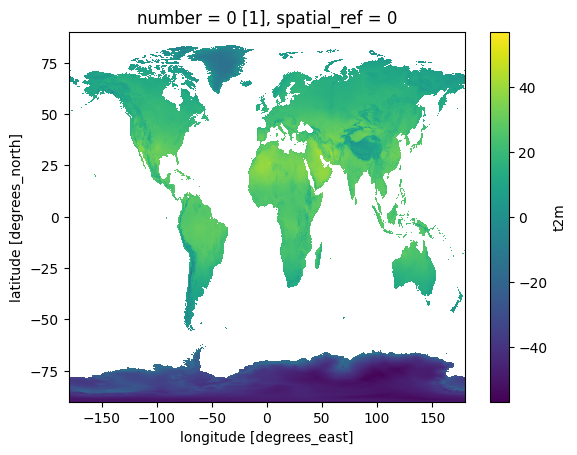

In [15]:
input = model.read_input_data().compute()
input["t2m"].mean(dim="valid_time").plot(cmap="viridis")

In [16]:
model.run()

In [17]:
data = xr.open_dataset(
            Path.cwd().parent / 'data' / "out" / "output_map_global.nc", engine="rasterio", chunks = None
        ).compute()

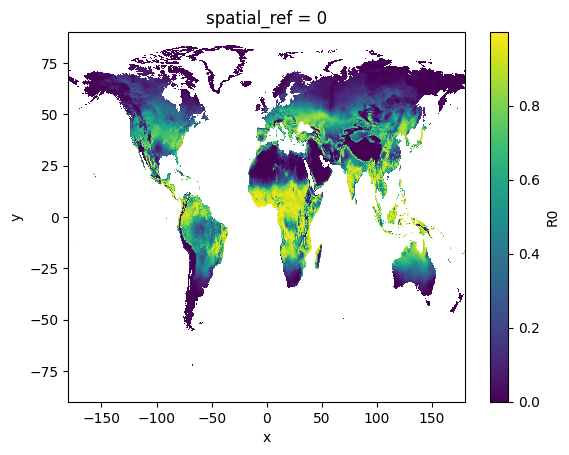

In [18]:
data["R0"].mean(dim="valid_time").plot(cmap="viridis")

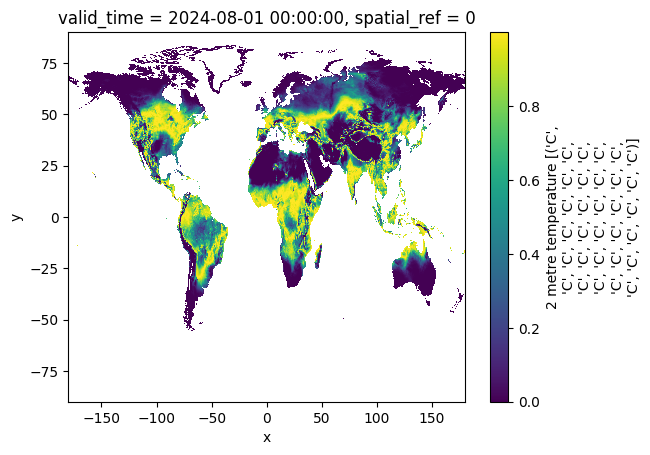

In [19]:
data["R0"].sel(valid_time = "2024-08-01").plot(cmap="viridis")

# Monthly data

## Build new model instance 

In [20]:
data_file = "era5_data_2024_01_02_03_2t_tp_monthly_celsius_mm_resampled_05degree_trim.nc"

In [21]:
model = mdc.JModel(
    input = path / data_file, 
    output = Path.cwd().parent / 'data' / "out" / "output_map_monthly.nc", 
    r0_path= path / "R0_pip_stats.csv",
    run_mode="forbidden", 
    grid_data_baseurl="https://gisco-services.ec.europa.eu/distribution/v2/nuts",
    nuts_level =3, 
    resolution = "10M", 
    year=2024, 
)

In [22]:
data = model.read_input_data().compute()
data

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 3, latitude: 204, longitude: 236)
Coordinates:
    number       int64 8B 0
  * time         (time) datetime64[ns] 24B 2024-01-01 2024-02-01 2024-03-01
    expver       (time) <U4 48B '0001' '0001' '0001'
  * latitude     (latitude) float64 2kB 80.25 79.75 79.25 ... -20.75 -21.25
  * longitude    (longitude) float64 2kB -61.75 -61.25 -60.75 ... 55.25 55.75
    spatial_ref  int64 8B 0
Data variables:
    t2m          (time, latitude, longitude) float32 578kB nan nan ... nan 21.5
    tp           (time, latitude, longitude) float32 578kB nan nan ... nan 7.083
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-13T12:17 GRIB to CDM+CF via cfgrib-0.9.1...

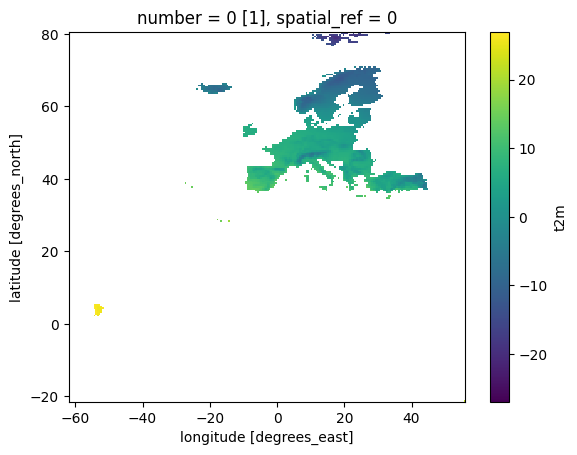

In [23]:
data["t2m"].mean(dim="time").plot(cmap="viridis")

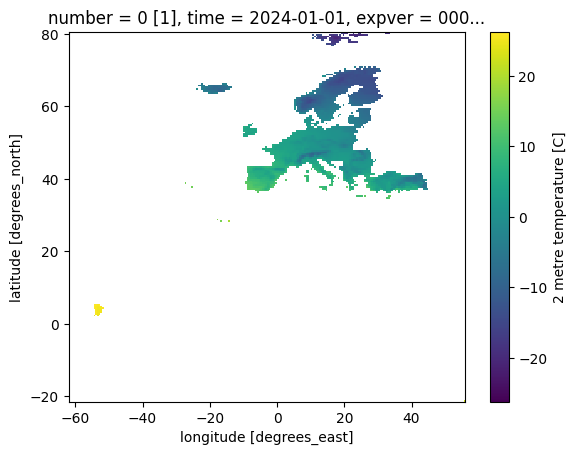

In [24]:
data["t2m"].sel(time = "2024-01-01").plot(cmap="viridis")

## run the model again

In [25]:
model.run()

In [26]:
data = xr.open_dataset(
            Path.cwd().parent / 'data' / "out" / "output_map_monthly.nc",engine="rasterio", chunks = None
        ).compute()

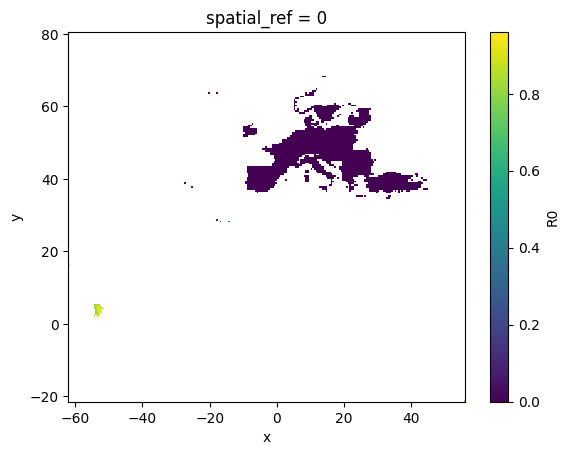

In [27]:
data["R0"].mean(dim="time").plot(cmap="viridis")

since it's always summer in French Guiana by comparison, we have high transmissivity there, but literally nothing in europe where it's cold. 

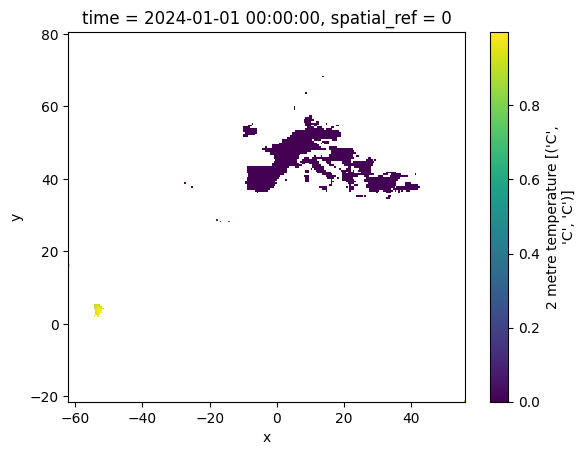

In [28]:
data["R0"].sel(time = "2024-01-01").plot(cmap="viridis")